This file contains code that runs a statistical comparison between stock prediction models that use sentiment data, and those that do not

In [1]:
import pandas as pd
import time
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt
finnhub_key = 'YOUR_API_KEY'

current_time = 1666444872889

In [4]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from mlxtend.evaluate import paired_ttest_5x2cv

# Processing stocks data

In [18]:
stocks_df = pd.read_csv('stocks_data.csv')
stocks_df = stocks_df.iloc[:, 1:]
stocks_df['t'] = pd.to_datetime(stocks_df['t']).dt.date
stocks_df = stocks_df.dropna()

In [19]:
# relative change calculation is wrong, sp multiply all features by -1
stock_features = [f'{lag+1}_{feature}' for lag in range(5) for feature in ['c', 'h', 'l', 'o', 'v']]
stocks_df[stock_features] = stocks_df[stock_features] * -1
stocks_df['target'] = stocks_df['target'] * -1

stocks_df

,t,target,1_c,1_h,1_l,1_o,1_v,2_c,2_h,2_l,...,4_h,4_l,4_o,4_v,5_c,5_h,5_l,5_o,5_v,company
0,2001-01-02,-0.010891,-0.011790,-0.000000,0.029032,0.029009,-0.357576,0.023073,0.029844,0.016393,...,0.013773,0.011839,0.008337,-0.453661,0.000554,-0.004388,0.012557,0.008409,-0.239180,MMM
1,2001-01-03,-0.011538,-0.010891,-0.011694,-0.017764,-0.031267,0.688766,-0.011790,-0.000000,0.029032,...,0.038043,0.019498,0.022051,0.283057,0.019956,0.013773,0.011839,0.008337,-0.453661,MMM
2,2001-01-04,0.010080,-0.011538,-0.013374,-0.009574,-0.001058,0.022188,-0.010891,-0.011694,-0.017764,...,0.029844,0.016393,0.022654,0.671032,0.036414,0.038043,0.019498,0.022051,0.283057,MMM
3,2001-01-05,-0.037291,0.010080,-0.003128,-0.006983,-0.001059,-0.145970,-0.011538,-0.013374,-0.009574,...,-0.000000,0.029032,0.029009,-0.357576,0.023073,0.029844,0.016393,0.022654,0.671032,MMM
4,2001-01-08,0.006002,-0.037291,-0.020921,-0.043267,-0.007423,1.060634,0.010080,-0.003128,-0.006983,...,-0.011694,-0.017764,-0.031267,0.688766,-0.011790,-0.000000,0.029032,0.029009,-0.357576,MMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420999,2022-10-17,0.030193,-0.021798,0.006740,0.022838,0.054296,0.776079,0.019059,0.012499,-0.025551,...,0.002633,0.001108,-0.015733,0.009178,-0.010789,-0.021861,-0.017081,-0.019725,-0.224112,ZTS
2421000,2022-10-18,0.004206,0.030193,-0.003049,0.013094,-0.017233,-0.169498,-0.021798,0.006740,0.022838,...,-0.003233,0.006846,0.007958,-0.068966,0.003224,0.002633,0.001108,-0.015733,0.009178,ZTS
2421001,2022-10-19,-0.015224,0.004206,0.026461,0.018774,0.044722,0.276417,0.030193,-0.003049,0.013094,...,0.012499,-0.025551,-0.033553,0.002713,-0.002667,-0.003233,0.006846,0.007958,-0.068966,ZTS
2421002,2022-10-20,-0.024978,-0.015224,-0.028370,-0.025973,-0.028040,-0.287234,0.004206,0.026461,0.018774,...,0.006740,0.022838,0.054296,0.776079,0.019059,0.012499,-0.025551,-0.033553,0.002713,ZTS


In [20]:
indexed_stocks = stocks_df.set_index(['t', 'company'])
indexed_stocks

,,target,1_c,1_h,1_l,1_o,1_v,2_c,2_h,2_l,2_o,...,4_c,4_h,4_l,4_o,4_v,5_c,5_h,5_l,5_o,5_v
t,company,,,,,,,,,,,,,,,,,,,,,
2001-01-02,MMM,-0.010891,-0.011790,-0.000000,0.029032,0.029009,-0.357576,0.023073,0.029844,0.016393,0.022654,...,0.019956,0.013773,0.011839,0.008337,-0.453661,0.000554,-0.004388,0.012557,0.008409,-0.239180
2001-01-03,MMM,-0.011538,-0.010891,-0.011694,-0.017764,-0.031267,0.688766,-0.011790,-0.000000,0.029032,0.029009,...,0.036414,0.038043,0.019498,0.022051,0.283057,0.019956,0.013773,0.011839,0.008337,-0.453661
2001-01-04,MMM,0.010080,-0.011538,-0.013374,-0.009574,-0.001058,0.022188,-0.010891,-0.011694,-0.017764,-0.031267,...,0.023073,0.029844,0.016393,0.022654,0.671032,0.036414,0.038043,0.019498,0.022051,0.283057
2001-01-05,MMM,-0.037291,0.010080,-0.003128,-0.006983,-0.001059,-0.145970,-0.011538,-0.013374,-0.009574,-0.001058,...,-0.011790,-0.000000,0.029032,0.029009,-0.357576,0.023073,0.029844,0.016393,0.022654,0.671032
2001-01-08,MMM,0.006002,-0.037291,-0.020921,-0.043267,-0.007423,1.060634,0.010080,-0.003128,-0.006983,-0.001059,...,-0.010891,-0.011694,-0.017764,-0.031267,0.688766,-0.011790,-0.000000,0.029032,0.029009,-0.357576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,ZTS,0.030193,-0.021798,0.006740,0.022838,0.054296,0.776079,0.019059,0.012499,-0.025551,-0.033553,...,0.003224,0.002633,0.001108,-0.015733,0.009178,-0.010789,-0.021861,-0.017081,-0.019725,-0.224112
2022-10-18,ZTS,0.004206,0.030193,-0.003049,0.013094,-0.017233,-0.169498,-0.021798,0.006740,0.022838,0.054296,...,-0.002667,-0.003233,0.006846,0.007958,-0.068966,0.003224,0.002633,0.001108,-0.015733,0.009178
2022-10-19,ZTS,-0.015224,0.004206,0.026461,0.018774,0.044722,0.276417,0.030193,-0.003049,0.013094,-0.017233,...,0.019059,0.012499,-0.025551,-0.033553,0.002713,-0.002667,-0.003233,0.006846,0.007958,-0.068966


In [21]:
# feature engineering
column_suffixes_to_multiply = ['c', 'h', 'l', 'o', 'v']
for suffix in column_suffixes_to_multiply:
  columns_to_multiply = [column for column in indexed_stocks.columns if column.endswith(suffix)]
  new_feature_name = suffix + '_product'
  print(f'Multiplying columns {columns_to_multiply} into column {new_feature_name}')
  
  product = (indexed_stocks[columns_to_multiply] + 1).prod(axis=1)
  indexed_stocks[new_feature_name] = product
  
  stock_features.append(new_feature_name)

Multiplying columns ['1_c', '2_c', '3_c', '4_c', '5_c'] into column c_product
Multiplying columns ['1_h', '2_h', '3_h', '4_h', '5_h'] into column h_product
Multiplying columns ['1_l', '2_l', '3_l', '4_l', '5_l'] into column l_product
Multiplying columns ['1_o', '2_o', '3_o', '4_o', '5_o'] into column o_product
Multiplying columns ['1_v', '2_v', '3_v', '4_v', '5_v'] into column v_product


In [22]:
stock_features

['1_c',
 '1_h',
 '1_l',
 '1_o',
 '1_v',
 '2_c',
 '2_h',
 '2_l',
 '2_o',
 '2_v',
 '3_c',
 '3_h',
 '3_l',
 '3_o',
 '3_v',
 '4_c',
 '4_h',
 '4_l',
 '4_o',
 '4_v',
 '5_c',
 '5_h',
 '5_l',
 '5_o',
 '5_v',
 'c_product',
 'h_product',
 'l_product',
 'o_product',
 'v_product']

In [23]:
indexed_stocks.describe().T

,count,mean,std,min,25%,50%,75%,max
target,2420409.0,0.000586,0.023092,-0.699309,-0.009002,0.000512,0.010057,1.023578
1_c,2420409.0,0.000581,0.023094,-0.699309,-0.009006,0.000509,0.010050,1.023578
1_h,2420409.0,0.000524,0.020487,-0.681995,-0.007661,0.000052,0.008257,1.264398
1_l,2420409.0,0.000564,0.022090,-0.737303,-0.007707,0.000975,0.009262,2.406667
1_o,2420409.0,0.000588,0.023198,-0.740169,-0.009133,0.000585,0.010222,1.059160
1_v,2420409.0,inf,NaN,-1.000000,-0.225255,-0.012416,0.272957,inf
2_c,2420409.0,0.000586,0.023099,-0.699309,-0.009002,0.000512,0.010055,1.023578
2_h,2420409.0,0.000527,0.020492,-0.681995,-0.007660,0.000060,0.008259,1.264398
2_l,2420409.0,0.000568,0.022094,-0.737303,-0.007704,0.000977,0.009266,2.406667
2_o,2420409.0,0.000592,0.023203,-0.740169,-0.009132,0.000588,0.010226,1.059160


# Processing news data

In [82]:
news_df = pd.read_csv('intermediate_fetched_news.csv')
news_df['t'] = news_df['index'].rename('a')
news_df['t'] = pd.to_datetime(news_df['t']).dt.date
news_df = news_df.drop('index', axis=1)

In [83]:
news_df['daily_news_count'].sum()

383089

In [84]:
useless_columns = [
  'daily_positives_count', 'daily_negatives_count', 'daily_negatives_ratio',
  'daily_news_count']
news_df = news_df.drop(useless_columns, axis=1)
news_df = news_df.set_index(['t', 'company'])
news_df

,,mean_daily_positive_score,daily_positives_count,daily_positives_ratio,mean_daily_negative_score,daily_negatives_count,daily_negatives_ratio,daily_news_count,positivity,negativity,mood,...,monthly_buzz,weekly_relative_positivity,monthly_relative_positivity,weekly_relative_negativity,monthly_relative_negativity,weekly_relative_mood,monthly_relative_mood,difference_from_mood_week_ago,difference_from_mood_month_ago,nan_window_data
t,company,,,,,,,,,,,,,,,,,,,,,
2021-03-09,AAPL,0.746492,1,1.000000,0.000000,0,0.000000,1,0.746492,0.000000,0.746492,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0
2021-03-10,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-11,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-12,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-13,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,KR,0.944600,9,0.500000,0.965809,9,0.500000,18,0.472300,0.482905,-0.010604,...,2.488479,0.925066,1.041462,1.146254,1.596188,-0.118793,-0.070246,-0.182127,-0.010604,0.0
2022-10-18,KR,0.988043,7,0.350000,0.965281,13,0.650000,20,0.345815,0.627433,-0.281618,...,2.531646,0.687582,0.743649,1.468081,1.939810,-3.727034,-1.989191,-0.095955,-0.281618,0.0
2022-10-19,KR,0.994318,4,0.363636,0.907145,7,0.636364,11,0.361570,0.577274,-0.215704,...,1.380753,0.754892,0.787035,1.245068,1.754144,-14.079102,-1.655232,-0.421680,-0.337726,0.0


In [85]:
categorical_news_features = ['nan_window_data', 'no_news_today']
news_features_to_scale = [f for f in news_df.columns if f not in categorical_news_features]
news_features_to_scale

['mean_daily_positive_score',
 'daily_positives_count',
 'daily_positives_ratio',
 'mean_daily_negative_score',
 'daily_negatives_count',
 'daily_negatives_ratio',
 'daily_news_count',
 'positivity',
 'negativity',
 'mood',
 'weekly_buzz',
 'monthly_buzz',
 'weekly_relative_positivity',
 'monthly_relative_positivity',
 'weekly_relative_negativity',
 'monthly_relative_negativity',
 'weekly_relative_mood',
 'monthly_relative_mood',
 'difference_from_mood_week_ago',
 'difference_from_mood_month_ago']

In [86]:
news_df = np.clip(news_df, -10, 10)

In [87]:
news_df

,,mean_daily_positive_score,daily_positives_count,daily_positives_ratio,mean_daily_negative_score,daily_negatives_count,daily_negatives_ratio,daily_news_count,positivity,negativity,mood,...,monthly_buzz,weekly_relative_positivity,monthly_relative_positivity,weekly_relative_negativity,monthly_relative_negativity,weekly_relative_mood,monthly_relative_mood,difference_from_mood_week_ago,difference_from_mood_month_ago,nan_window_data
t,company,,,,,,,,,,,,,,,,,,,,,
2021-03-09,AAPL,0.746492,1,1.000000,0.000000,0,0.000000,1,0.746492,0.000000,0.746492,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0
2021-03-10,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-11,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-12,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2021-03-13,AAPL,0.000000,0,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,KR,0.944600,9,0.500000,0.965809,9,0.500000,10,0.472300,0.482905,-0.010604,...,2.488479,0.925066,1.041462,1.146254,1.596188,-0.118793,-0.070246,-0.182127,-0.010604,0.0
2022-10-18,KR,0.988043,7,0.350000,0.965281,10,0.650000,10,0.345815,0.627433,-0.281618,...,2.531646,0.687582,0.743649,1.468081,1.939810,-3.727034,-1.989191,-0.095955,-0.281618,0.0
2022-10-19,KR,0.994318,4,0.363636,0.907145,7,0.636364,10,0.361570,0.577274,-0.215704,...,1.380753,0.754892,0.787035,1.245068,1.754144,-10.000000,-1.655232,-0.421680,-0.337726,0.0


In [88]:
from sklearn import preprocessing

In [89]:
news_features = list(news_df.columns)

# Combining data

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

stock_features_transformer = ColumnTransformer(transformers=[
  ('standard_scaler', StandardScaler(), stock_features)
], remainder='passthrough')

news_features_transformer = ColumnTransformer(transformers=[
  ('power_scaler', preprocessing.PowerTransformer(method='yeo-johnson', standardize=True), news_features_to_scale)
], remainder='passthrough')

all_features_transformer = ColumnTransformer(transformers=[
  ('stocks_standard_scaler', StandardScaler(), stock_features),
  ('news_power_scaler', preprocessing.PowerTransformer(method='yeo-johnson', standardize=True), news_features_to_scale),
], remainder='passthrough')

#stock_features_transformer.fit_transform(stocks_df)

In [91]:
combined_df = indexed_stocks.join(news_df, how='inner')
combined_df

,,target,1_c,1_h,1_l,1_o,1_v,2_c,2_h,2_l,2_o,...,monthly_buzz,weekly_relative_positivity,monthly_relative_positivity,weekly_relative_negativity,monthly_relative_negativity,weekly_relative_mood,monthly_relative_mood,difference_from_mood_week_ago,difference_from_mood_month_ago,nan_window_data
t,company,,,,,,,,,,,,,,,,,,,,,
2021-10-27,MMM,-0.021520,-0.001316,0.004755,-0.001560,0.003158,0.159144,0.008850,-0.001855,-0.007357,-0.011338,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0
2021-10-28,MMM,0.009145,-0.021520,-0.008051,-0.006084,0.006627,-0.162202,-0.001316,0.004755,-0.001560,0.003158,...,0.842105,1.139374,1.139374,0.817423,0.817423,4.271219,4.271219,0.000000,0.000000,1.0
2021-10-29,MMM,-0.006616,0.009145,-0.012778,0.000898,-0.022055,-0.259650,-0.021520,-0.008051,-0.006084,0.006627,...,0.964286,1.136102,1.136102,0.576730,0.576730,2.425694,2.425694,0.000000,0.000000,1.0
2021-11-01,MMM,0.005037,-0.006616,0.005000,-0.000673,0.008191,0.316006,0.009145,-0.012778,0.000898,-0.022055,...,0.882353,0.951728,0.951728,1.215629,1.215629,1.898744,1.898744,0.000000,0.000000,1.0
2021-11-02,MMM,0.013309,0.005037,-0.006467,-0.003425,-0.006566,-0.214495,-0.006616,0.005000,-0.000673,0.008191,...,0.736842,1.952450,1.952450,0.597081,0.597081,-10.000000,-10.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17,MSFT,0.039246,-0.024249,0.004828,0.042030,0.071367,-0.290578,0.037608,0.036163,-0.021566,-0.024623,...,1.268759,1.547547,1.530143,0.700940,0.698723,-0.325631,-0.327850,0.413255,0.385395,0.0
2022-10-18,MSFT,0.004084,0.039246,0.007250,0.029780,0.001189,-0.067741,-0.024249,0.004828,0.042030,0.071367,...,1.664516,0.994992,0.941328,1.028129,1.054065,1.066537,1.210877,-0.064691,0.688651,0.0
2022-10-19,MSFT,-0.008470,0.004084,0.020798,0.000978,0.031465,-0.064412,0.039246,0.007250,0.029780,0.001189,...,1.482890,0.817914,0.767643,1.104589,1.150331,1.420998,1.683511,-0.085093,0.007107,0.0


In [41]:
pd.Series(combined_df.index.get_level_values(1)).unique()

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE',
       'AAP', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB',
       'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AMCR', 'AEE', 'AAL', 'AEP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC',
       'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT',
       'APTV', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO',
       'AVB', 'AVY', 'BKR', 'BAC', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIO',
       'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX',
       'BMY', 'AVGO', 'BR', 'BRO', 'CHRW', 'CDNS', 'CZR', 'CPB', 'COF',
       'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW',
       'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX',
       'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG',
       'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA',
       'CAG', 'COP', 'ED', 'STZ', 'CPRT', 'GLW', 'CTVA', 'COST', '

In [93]:
combined_df['daily_news_count'].sum()

251141

In [42]:
# target will signify wether or not the change in price was positive
combined_df['target'] = (combined_df['target'] > 0).astype(int)

# because the dataset is balanced, accuracy is a useful metric for comparing models
combined_df['target'].mean()

0.4995346620057203

In [43]:
combined_df.groupby(combined_df.index.get_level_values(1)).count().iloc[:, 0].describe()

count    267.000000
mean     329.992509
std      146.019208
min      233.000000
25%      247.000000
50%      248.000000
75%      344.000000
max      703.000000
Name: target, dtype: float64

# Running model comparison

In [44]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_models():
  models = {
    'logistic_regression': (LogisticRegression, {'random_state': 0,
                                                 'max_iter': 1000,
                                                 'n_jobs': -1}),
    'NB': (GaussianNB, {}),
    'random_forest': (RandomForestClassifier, {'n_estimators':256,
                                               'random_state':0,
                                               'n_jobs':-1,
                                               'max_depth':10}),
    'KNN': (KNeighborsClassifier, {'n_jobs':-1}),
    'GBC': (GradientBoostingClassifier, {'n_estimators':256,
                                         'random_state': 0}),
    'decision_tree': (DecisionTreeClassifier, {}),
  }
  return models

In [45]:
class ClassifierWithoutSentiment:
  def __init__(self, classifier):
    self.classifier = classifier

  # keeps only the first len(stock_features) columns
  def cut_out_sentiment_data(self, data):
    return data[:, :len(stock_features)]
    
  def fit(self, X, y):
    X = self.cut_out_sentiment_data(X)
    self.classifier.fit(X, y)
    return self

  def predict(self, X, y=None):
    X = self.cut_out_sentiment_data(X)
    return self.classifier.predict(X)
  
  def score(self, X, y):
    X = self.cut_out_sentiment_data(X)
    return self.classifier.score(X, y)
  
  def predict_proba(self, X, y=None):
    X = self.cut_out_sentiment_data(X)
    return self.classifier.predict_proba(X)

In [46]:
all_features_df = combined_df.drop('target', axis=1)
target_column = combined_df['target']

In [47]:
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import train_test_split

results = []
models_to_test = get_models()

X = all_features_transformer.fit_transform(all_features_df)
y = target_column.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0, stratify=y)

for model_name, (model_class, model_params) in models_to_test.items():
  print(f'Testing model {model_name}')
  
  model_with_sentiments = model_class(**model_params)
  model_without_sentiments = ClassifierWithoutSentiment(model_class(**model_params))
  
  with_sentiments_accuracy = model_with_sentiments.fit(X_train, y_train).score(X_test, y_test)
  without_sentiments_accuracy = model_without_sentiments.fit(X_train, y_train).score(X_test, y_test)

  print(f'Accuracy with sentiments: {with_sentiments_accuracy*100:.2f}%')
  print(f'Accuracy without sentiments: {without_sentiments_accuracy*100:.2f}%')
  
  # check if difference between algorithms is significant
  t, p = paired_ttest_5x2cv(estimator1=model_with_sentiments, 
                            estimator2=model_without_sentiments, 
                            X=X, 
                            y=y, 
                            scoring='accuracy', 
                            random_seed=0)
  results.append({'model': model_name,
                  'acc_with_sentiments': with_sentiments_accuracy,
                  'acc_without_sentiments': without_sentiments_accuracy,
                  't': t,
                  'p': p})
  
  print(f'Statistic {t}, {p}')
  print()
  
  

Testing model logistic_regression
Accuracy with sentiments: 58.46%
Accuracy without sentiments: 52.69%


KeyboardInterrupt: ignored

In [ ]:
results_df = pd.DataFrame(results)
results_df

,model,acc_with_sentiments,acc_without_sentiments,t,p
0,logistic_regression,0.584400,0.526929,23.762344,0.000002
1,NB,0.573428,0.515064,19.063102,0.000007
2,random_forest,0.625224,0.604794,8.477135,0.000375


In [80]:
# depth = 12

forest, forest_params = get_models()['random_forest']
forest = forest(156, max_depth=10, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, forest.predict(X_train)))
print(accuracy_score(y_test, forest.predict(X_test)))

0.6874745900528527
0.6121887467327005


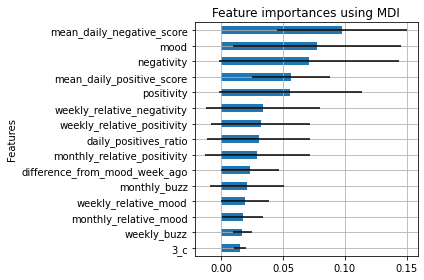

In [81]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame({'i': importances, 's': std}, index=all_features_df.columns)
forest_importances = forest_importances
forest_importances = forest_importances.sort_values('i')
forest_importances = forest_importances.iloc[-15:]
#display(forest_importances)

fig, ax = plt.subplots()
forest_importances['i'].plot.barh(xerr=forest_importances['s'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Features")
ax.grid(True)
fig.tight_layout()

0.7568437457650088
0.6175883890493878


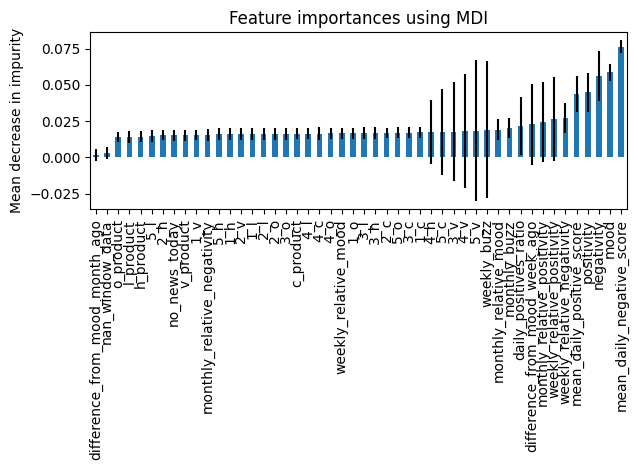

In [ ]:
# depth = 12

forest, forest_params = get_models()['random_forest']
forest = forest(**forest_params)
forest.fit(X_train, y_train)
print(accuracy_score(y_train, forest.predict(X_train)))
print(accuracy_score(y_test, forest.predict(X_test)))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=all_features_df.columns)
forest_importances = forest_importances.sort_values()

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
importances.min(), importances.max()

(0.0015698762101664368, 0.07621662705648574)

In [ ]:
results_df.sort_values('t')

,model,acc_with_sentiments,acc_without_sentiments,t,p
5,decision_tree,0.556109,0.540545,3.292663,2.164986e-02
3,KNN,0.600981,0.599569,5.404974,2.930453e-03
2,random_forest,0.612682,0.579399,11.530875,8.602366e-05
4,GBC,0.610787,0.554288,19.334154,6.828258e-06
0,logistic_regression,0.583262,0.523049,26.928610,1.320805e-06
1,NB,0.576279,0.515917,33.234182,4.636340e-07


In [ ]:
pd.DataFrame(kfold_results).groupby(['dataset'])[['accuracy', 'f1']].mean()

,accuracy,f1
dataset,,
stock_only,0.541057,0.546524
with_news,0.592833,0.619817
